In [2]:
import numpy as np
from scipy import ndimage
import cv2 as cv

In [3]:
def canny_edge(image):
    threshold_weak = None
    threshold_strong = None
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    sigma = 5
    kernel_size = 5
    size = int(kernel_size) // 2
    x, y = np.mgrid[-size:size + 1, -size:size + 1]
    normal = 1 / (2.0 * np.pi * sigma ** 2)
    gaussian_kernel = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2))) * normal

    image = cv.filter2D(src=image, kernel=gaussian_kernel, ddepth=19)

    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Image_x = ndimage.filters.convolve(image, Kx)
    Image_y = ndimage.filters.convolve(image, Ky)

    G = np.hypot(Image_x, Image_y)
    magnitude = G / G.max() * 255
    theta = np.arctan2(Image_y, Image_x)
    max_magnitude = np.max(magnitude)
    if not threshold_weak:
        threshold_weak = max_magnitude * 0.1

    if not threshold_strong:
        threshold_strong = max_magnitude * 0.5

    height, width = image.shape

   
    for x in range(width):
        for y in range(height):

            grad = theta[y, x]
            grad = abs(grad - 180) if abs(grad) > 180 else abs(grad)

        
            if grad <= 22.5:
                n1x, n1y = x - 1, y
                n2x, n2y = x + 1, y

            elif 22.5 < grad <= (22.5 + 45):
                n1x, n1y = x - 1, y - 1
                n2x, n2y = x + 1, y + 1

           
            elif (22.5 + 45) < grad <= (22.5 + 90):
                n1x, n1y = x, y - 1
                n2x, n2y = x, y + 1

      
            elif (22.5 + 90) < grad <= (22.5 + 135):
                n1x, n1y = x - 1, y + 1
                n2x, n2y = x + 1, y - 1

            
            elif (22.5 + 135) < grad <= (22.5 + 180):
                n1x, n1y = x - 1, y
                n2x, n2y = x + 1, y

            
            if width > n1x >= 0 and height > n1y >= 0:
                if magnitude[y, x] < magnitude[n1y, n1x]:
                    magnitude[y, x] = 0
                    continue

            if width > n2x >= 0 and height > n2y >= 0:
                if magnitude[y, x] < magnitude[n2y, n2x]:
                    magnitude[y, x] = 0

    ids = np.zeros_like(image)
    
    for x in range(width):
        for y in range(height):

            grad_mag = magnitude[y, x]

            if grad_mag < threshold_weak:
                magnitude[y, x] = 0
            elif threshold_strong > grad_mag >= threshold_weak:
                ids[y, x] = 1
            else:
                ids[y, x] = 2

    return magnitude


In [4]:
def harris_corners(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dist = cv.cornerHarris(gray, 2, 3, 0.04)
    # result is dilated for marking the corners, not important
    dist = cv.dilate(dist, None)
    # Threshold for an optimal value, it may vary depending on the image.
    image[dist > 0.01 * dist.max()] = [0, 0, 255]
    return image

In [5]:
def visualize_image(frame_name, frame):
    cv.imshow(frame_name, frame)
    cv.imwrite(frame_name + ".jpg", frame)
    if cv.waitKey(0) == ord('q'):
        cv.destroyAllWindows()

In [7]:
if __name__ == "__main__":
    cap = cv.VideoCapture("CV Video.mp4")
    frames_dict = {}
    count = 0
    while cap.read()[0]:
        frames_dict[count] = cap.read()[1]
        count += 1
    print(frames_dict)
    frame = frames_dict[90]
    cv.imshow("Frame", frame)
    visualize_image("Frame", frame)

    canny_image = canny_edge(frame)
    visualize_image("Canny", canny_image)

    harris_image = canny_edge(frame)
    visualize_image("Harris", harris_image)

{0: array([[[25, 31, 34],
        [25, 31, 34],
        [25, 31, 34],
        ...,
        [18, 28, 46],
        [18, 28, 46],
        [18, 28, 46]],

       [[25, 31, 34],
        [25, 31, 34],
        [25, 31, 34],
        ...,
        [18, 28, 46],
        [18, 28, 46],
        [18, 28, 46]],

       [[24, 30, 33],
        [24, 30, 33],
        [24, 30, 33],
        ...,
        [18, 28, 46],
        [18, 28, 46],
        [18, 28, 46]],

       ...,

       [[33, 53, 81],
        [33, 53, 81],
        [34, 54, 82],
        ...,
        [25, 44, 63],
        [25, 44, 63],
        [25, 44, 63]],

       [[33, 53, 81],
        [33, 53, 81],
        [34, 54, 82],
        ...,
        [25, 44, 63],
        [25, 44, 63],
        [25, 44, 63]],

       [[33, 53, 81],
        [33, 53, 81],
        [34, 54, 82],
        ...,
        [25, 44, 63],
        [25, 44, 63],
        [25, 44, 63]]], dtype=uint8), 1: array([[[25, 31, 34],
        [25, 31, 34],
        [25, 31, 34],
        ...,
     

2024-04-21 21:11:16.742 Python[43550:3241757] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.
/var/folders/3n/gb1_zg1s1qxdh0jcmf5zwl600000gn/T/ipykernel_43550/3925242218.py:17: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Image_x = ndimage.filters.convolve(image, Kx)
/var/folders/3n/gb1_zg1s1qxdh0jcmf5zwl600000gn/T/ipykernel_43550/3925242218.py:18: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Image_y = ndimage.filters.convolve(image, Ky)


[[6.5000000e+01 1.3000000e+02 1.9500000e+02 ... 4.0538000e+04
  4.0600000e+04 4.0662000e+04]
 [1.3000000e+02 2.6000000e+02 3.9000000e+02 ... 8.1122000e+04
  8.1246000e+04 8.1370000e+04]
 [1.9500000e+02 3.9000000e+02 5.8500000e+02 ... 1.2170600e+05
  1.2189200e+05 1.2207800e+05]
 ...
 [1.4069300e+05 2.8125300e+05 4.2168000e+05 ... 7.1030742e+07
  7.1126157e+07 7.1221829e+07]
 [1.4094300e+05 2.8175300e+05 4.2243000e+05 ... 7.1101295e+07
  7.1196764e+07 7.1292490e+07]
 [1.4119300e+05 2.8225300e+05 4.2318000e+05 ... 7.1171822e+07
  7.1267345e+07 7.1363125e+07]]


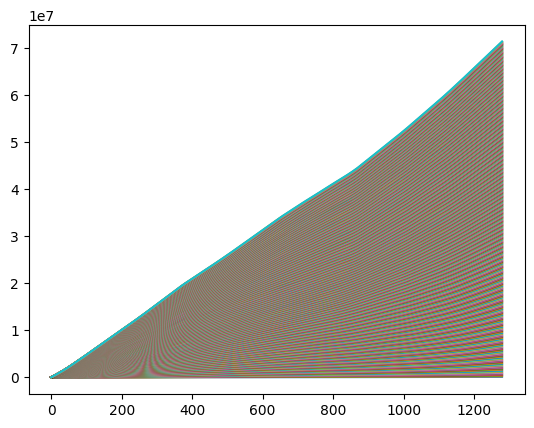

In [6]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

frame = cv.imread("Frame.jpg")
gray_clr = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
height, width = gray_clr.shape

intergal_image = np.zeros((height, width))

for i in range(height):
    for j in range(width):
        intergal_image[i][j] = int(gray_clr[i][j])

for i in range(1, width):
    intergal_image[0][i] += intergal_image[0][i - 1]

for j in range(1, height):
    intergal_image[j][0] += intergal_image[j - 1][0]

for i in range(1, height):
    for j in range(1, width):
        intergal_image[i][j] = intergal_image[i - 1][j] + intergal_image[i][j - 1] - intergal_image[i - 1][j - 1] + gray_clr[i][j]

print(intergal_image)
np.savetxt('integral_matrix.txt', intergal_image, fmt='%d')
plt.plot(intergal_image)
plt.savefig("integral_image.jpg")
plt.show()

In [3]:
import cv2 as cv
import numpy as np


def extract_features_sift_and_stitch_images(frame1, frame2):
    gray_1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
    gray_2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)

    algortihm = cv.SIFT_create()

    kp_img1, desc_img1 = algortihm.detectAndCompute(gray_1, None)
    kp_img2, desc_img2 = algortihm.detectAndCompute(gray_2, None)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(desc_img2, desc_img1, k=2)

    features = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            features.append(m)

    query_pts = np.float32([kp_img2[m.queryIdx]
                           .pt for m in features]).reshape(-1, 1, 2)
    train_pts = np.float32([kp_img1[m.trainIdx]
                           .pt for m in features]).reshape(-1, 1, 2)

    matrix, mask = cv.findHomography(query_pts, train_pts, cv.RANSAC, 5.0)
    dst = cv.warpPerspective(frame2, matrix, ((frame1.shape[1] + frame2.shape[1]), frame2.shape[0]))
    dst[0:frame1.shape[0], 0:frame1.shape[1]] = frame1
    return dst


def visualize_image(frame_name, frame):
    cv.imshow(frame_name, frame)
    cv.imwrite(frame_name +".jpg", frame)
    if cv.waitKey(0) == ord('q'):
        cv.destroyAllWindows()


if __name__ == "__main__":
    frame1 = cv.imread('p2.jpeg')
    visualize_image("Frame1", frame1)

    frame2 = cv.imread('p4.jpeg')
    visualize_image("Frame2", frame2)

    stitched_image = extract_features_sift_and_stitch_images(frame1, frame2)

    visualize_image("Stitched Image - SIFT", stitched_image)

2024-04-21 18:26:57.442 Python[41636:3129401] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


In [4]:
import cv2 as cv
import numpy as np


def extract_features_sift_and_stitch_images(frame1, frame2):
    gray_1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
    gray_2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)

    algortihm = cv.SIFT_create()

    kp_img1, desc_img1 = algortihm.detectAndCompute(gray_1, None)
    kp_img2, desc_img2 = algortihm.detectAndCompute(gray_2, None)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(desc_img2, desc_img1, k=2)

    features = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            features.append(m)

    query_pts = np.float32([kp_img2[m.queryIdx]
                           .pt for m in features]).reshape(-1, 1, 2)
    train_pts = np.float32([kp_img1[m.trainIdx]
                           .pt for m in features]).reshape(-1, 1, 2)

    matrix, mask = cv.findHomography(query_pts, train_pts, cv.RANSAC, 5.0)
    dst = cv.warpPerspective(frame2, matrix, ((frame1.shape[1] + frame2.shape[1]), frame2.shape[0]))
    dst[0:frame1.shape[0], 0:frame1.shape[1]] = frame1
    
    cv.imwrite("/static/stitched-image.jpg", dst)
    
    return "/static/stitched-image.jpg"


frame1 = cv.imread('p2.jpeg')
frame2 = cv.imread('p4.jpeg')
stitched_image = extract_features_sift_and_stitch_images(frame1, frame2)

#Q3#

In [5]:
import cv2
import numpy as np

# Load the images
image1 = cv2.imread('img1.jpeg')  # Replace 'image1.jpg' with the path to your first image
image2 = cv2.imread('img2.jpeg')  # Replace 'image2.jpg' with the path to your second image

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Initialize BFMatcher
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw top matches
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display and save the matched image
cv2.imshow('Matches', matched_image)
cv2.imwrite('matched_image.jpg', matched_image)

# Extract matched keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

## b

# Compute Homography
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

# Compute inverse of Homography
H_inv = np.linalg.inv(H)

# Display and save the Homography matrix
print("Homography Matrix:")
print(H)
np.savetxt('homography_matrix.txt', H)

print("Inverse of Homography Matrix:")
print(H_inv)
np.savetxt('homography_matrix_inverse.txt', H_inv)

cv2.waitKey(0)
cv2.destroyAllWindows()

Homography Matrix:
[[-1.02721755e-01 -1.89289331e-01  1.97491812e+02]
 [-3.02648451e-01 -5.53946288e-01  5.78031964e+02]
 [-5.21769415e-04 -9.59042656e-04  1.00000000e+00]]
Inverse of Homography Matrix:
[[ 1.62937116e+03 -4.50892158e+02 -6.11573832e+04]
 [ 4.15864300e+03  1.28214826e+03 -1.56242062e+06]
 [ 4.83847206e+00  9.94373134e-01 -1.52933807e+03]]
